In [45]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

from model import ZeroTTT
from database import DataBase

In [56]:
# Hyperparams:
epochs = 1
lr = 3e-4
weight_decay = 1e-4

batch_size=400
'''
Remember that last index of 0th batch is 39
                            1st batch is 81
                            2nd batch is 146
                            
                            81 - 146 is "BAD DATA" generating more data in hopes it won't be bad, while
                            finding out what "BAD DATA" means

'''

'\nRemember that last index of 0th batch is 39\n                            1st batch is 81\n                            2nd batch is 146\n                            \n                            81 - 146 is "BAD DATA" generating more data in hopes it won\'t be bad, while\n                            finding out what "BAD DATA" means\n\n'

In [47]:
database = DataBase()
db_path = "/storage/replay_buffer"
model = ZeroTTT(brain_path="test_trained_model_0", opt_path="test_trained_opt_state_0", lr=lr, weight_decay=weight_decay, board_len=10)
# model = ZeroTTT(brain_path=None, opt_path=None, lr=lr, weight_decay=weight_decay, board_len=10)

Loading brain...


In [48]:
print(model.get_parameter_count())

183432


In [49]:
state_paths = [os.path.join(db_path, "states", name) for name in sorted(os.listdir("/storage/replay_buffer/states"))]
policy_paths = [os.path.join(db_path, "policy_labels", name) for name in sorted(os.listdir("/storage/replay_buffer/policy_labels"))]
value_paths = [os.path.join(db_path, "value_labels", name) for name in sorted(os.listdir("/storage/replay_buffer/value_labels"))]

names = list(zip(state_paths, policy_paths, value_paths))
filtered_names = []

for i in range(len(names)):
    index = int(names[i][0].split("_")[-1][:-4])
    if 39 < index < 82:
        filtered_names.append(names[i])
names = filtered_names
#test_set = names[-2:]
#names = names[:-2]
test_set = []

In [50]:
len(names)

42

In [51]:
def test_loss(model):
    model.brain.eval()
    total_p_loss = 0.0
    total_v_loss = 0.0
    for s, p, v in test_set:
        batch_sts, batch_pls, batch_vls = database.prepare_batches(batch_size=batch_size, from_memory_paths=(s, p, v))
        for b_nr in range(len(batch_sts)):
            batch_st, batch_pl, batch_vl = batch_sts[b_nr], batch_pls[b_nr], batch_vls[b_nr]
            
            batch_pl = torch.from_numpy(batch_pl).to(model.device)
            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_policy=False)
            val = val.flatten()

            p_loss = model.policy_loss(prob, batch_pl)
            v_loss = model.value_loss(val, batch_vl)
        
            total_p_loss += p_loss.item()
            total_v_loss += v_loss.item()
    return total_p_loss/(len(batch_sts)*len(test_set)), total_v_loss/(len(batch_sts)*len(test_set))

In [53]:
train_policy_losses = []
train_value_losses = []
test_policy_losses = []
test_value_losses = []
for e in range(epochs):
    model.brain.train()
    cumulative_policy_epoch_loss = 0.0
    cumulative_value_epoch_loss = 0.0
    for s_name, p_name, v_name in names:
        batch_sts, batch_pls, batch_vls = database.prepare_batches(batch_size=batch_size, from_memory_paths=(s_name, p_name, v_name))
        for b_nr in range(len(batch_sts)):
            
            model.optimizer.zero_grad()
            batch_st, batch_pl, batch_vl = batch_sts[b_nr], batch_pls[b_nr], batch_vls[b_nr]
            
            batch_pl = torch.from_numpy(batch_pl).to(model.device)
            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_output=False)
            val = val.flatten()

            p_loss = model.policy_loss(prob, batch_pl)
            # p_loss /= 4.0
            v_loss = model.value_loss(val, batch_vl)
            
            train_policy_losses.append(p_loss.item())
            train_value_losses.append(v_loss.item())
                        
            cumulative_policy_epoch_loss += p_loss.item()
            cumulative_value_epoch_loss += v_loss.item()

            loss = p_loss + v_loss
            loss.backward()
   
            model.optimizer.step()
    
    # Loss on test set:
    cumulative_policy_epoch_loss /= len(names)*len(batch_sts) # div by batch count
    cumulative_value_epoch_loss /= len(names)*len(batch_sts)
    # test_epoch_policy_loss, test_epoch_value_loss = test_loss(model)
    print(f"Epoch #{e} train policy loss: {cumulative_policy_epoch_loss} | train value loss: {cumulative_value_epoch_loss}")
    # print(f"Test policy loss: {test_epoch_policy_loss} | Test value loss: {test_epoch_value_loss}")
    train_policy_losses.append(cumulative_policy_epoch_loss)
    train_value_losses.append(cumulative_value_epoch_loss)
    # test_policy_losses.append(test_epoch_policy_loss)
    # test_value_losses.append(test_epoch_value_loss)
    # Checkpoint:
    model.save_brain("test_trained_model_1", "test_trained_opt_state_1")

Epoch #0 train policy loss: 4.17419781388086 | train value loss: 0.9274297834010351
Saving brain...


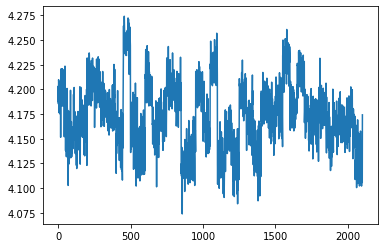

In [54]:
plt.plot(train_policy_losses)
# plt.plot(test_policy_losses)
plt.show()

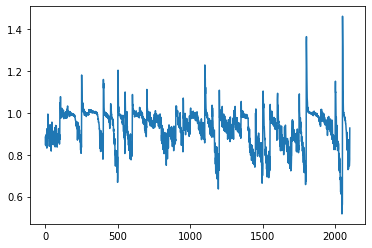

In [55]:
plt.plot(train_value_losses)
# plt.plot(test_policy_losses)
plt.show()